In [2]:
import numpy as np
import matplotlib.pyplot as plt
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.ops import FermionOperator
from openfermionpyscf import run_pyscf
from pyscf import fci
from qulacs import Observable, QuantumState, QuantumCircuit
from qulacs.observable import create_observable_from_openfermion_text
from qulacs.gate import X,Y,Z,H,RZ,RX,CZ,merge

from scipy.optimize import minimize
import matplotlib.pyplot as plt

## ハミルトニアンの計算
JW変換で分子のハミルトニアンを計算して，固有値を計算した

In [3]:
def H_chain_geometry(N:int,d:int)->list:
    """
    return H chain geometry as list
    """
    geometry = []
    for i in range(N):
        geometry.append(["H",[0,0,round(d*i,5)]])
    return geometry

def HE_Ansatz_Circuit(N,depth,theta_list):
    """
    Hardware Efficient Ansatz Circuit
    """
    circuit = QuantumCircuit(N)
    for d in range(depth):
        for i in range(N):
            circuit.add_gate(
                merge(
                    merge(RZ(i, theta_list[3*i+3*N*d]),RX(i, theta_list[3*i+1+3*N*d])),RZ(i, theta_list[3*i+2+2*N*d])
                     ))
        for i in range(N//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(N//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(N):
        circuit.add_gate(merge(RX(i, theta_list[2*i+3*N*depth]), RZ(i, theta_list[2*i+1+3*N*depth])))
    return circuit

## get expectation values
def expectation(state,theta_list):
    circuit = HE_Ansatz_Circuit(nqubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state)

## Cost Function
def cost(theta_list:list):
    weight_list = [k-i for i in range(nqubit)]
    ans=0
    for i in range(k):
        state = QuantumState(nqubit)
        state.set_computational_basis(i)
        expec = expectation(state,theta_list)
        ans += weight_list[i] * expec
    return ans


geometry = H_chain_geometry(N=2,d=0.7414)
basis = "sto-3g"
multiplicity = 1
charge = 0

molecule=MolecularData(geometry,basis,multiplicity,charge)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
nqubit,nelectron = molecule.n_qubits,molecule.n_electrons

fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
jw_hamiltonian_array=get_sparse_operator(jw_hamiltonian).toarray()
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

hf_energy= molecule.hf_energy
fci_energy= molecule.fci_energy
print({"HF energy": hf_energy, "FCI energy": fci_energy})
print(nqubit,nelectron)

exact_energy_list = sorted(np.linalg.eigvals(jw_hamiltonian_array))
print(exact_energy_list)

{'HF energy': -1.116684387085341, 'FCI energy': -1.137270174660903}
4 2
[(-1.1372701746609022+0j), (-0.5387095798772804+0j), (-0.5387095798772803+0j), (-0.5324790068861721+0j), (-0.5324790068861721+0j), (-0.532479006886172+0j), (-0.44698571767066353+0j), (-0.44698571767066353+0j), (-0.16990139046317976+0j), (0.23780527846665392+0j), (0.23780527846665397+0j), (0.3524341417394601+0j), (0.3524341417394601+0j), (0.47983611824427963+0j), (0.7137539936876182+0j), (0.9201067191670409+0j)]


## Ansatz and optimization 

In [4]:
## Optimizations
depth=nqubit
k = 3

energy_history_list = []


init_theta_list = np.random.random(nqubit*(3*depth+2))*2*np.pi

method = "BFGS"

options = {"disp": True, "maxiter": 100, "gtol": 1e-4}
def callback(theta_list):
    if len(energy_history_list)==0:
        for i in range(k):
            energy_history_list.append([])
    for i in range(k):
        state=QuantumState(nqubit)
        state.set_computational_basis(i)
        energy_history_list[i].append(expectation(state,theta_list))
    #print(len(energy_history_list[0]),[energy_history_list[i][-1] for i in range(k)])
    
opt = minimize(cost, init_theta_list,
               method=method,
               callback=callback)

/Users/masahikokamoshita/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/masahikokamoshita/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/masahikokamoshita/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


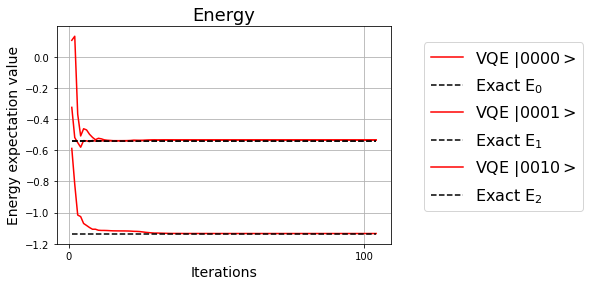

-1.137270174660903 [-1.1346702512497788, -0.5339742290879681, -0.5339742290811746]


In [5]:
n_itr = len(energy_history_list[0])
x = np.array([i+1 for i in range(n_itr)])

for i in range(k):
    plt.plot(x,energy_history_list[i],color='red',label='VQE $|{}>$'.format(bin(i)[2:].zfill(nqubit)))
    plt.plot(x,np.array([exact_energy_list[i] for j in range(n_itr)]),color='black',linestyle='--',label='Exact E$_{}$'.format(i))

plt.title('Energy',size=18)#title
plt.xlabel('Iterations',size=14)
plt.ylabel('Energy expectation value',size=14)
plt.grid()
plt.xticks([100*i for i in range(len(x)//100+1)])
plt.yticks()
plt.legend(bbox_to_anchor=(1.05, 1),borderaxespad=1,fontsize=16, loc='upper left')
plt.show()

print(fci_energy,[energy_history_list[i][-1] for i in range(3)])